In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

In [313]:
df=pd.read_csv('Loan_default.csv')

In [314]:
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [316]:
df.duplicated().sum()

np.int64(0)

In [317]:
df = df.drop(columns=["LoanID"])


In [318]:
print(df["LoanTerm"].value_counts())


LoanTerm
48    51166
60    51154
36    51061
24    51009
12    50957
Name: count, dtype: int64


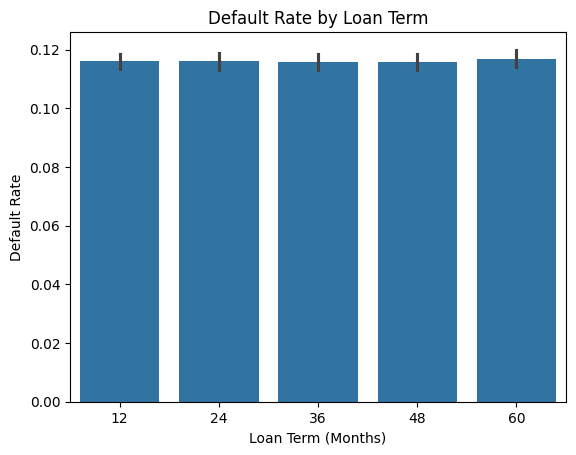

In [319]:

sns.barplot(x=df["LoanTerm"], y=df["Default"])
plt.xlabel("Loan Term (Months)")
plt.ylabel("Default Rate")
plt.title("Default Rate by Loan Term")
plt.show()


In [320]:
print(df[["LoanTerm", "InterestRate", "LoanAmount"]].corr())


              LoanTerm  InterestRate  LoanAmount
LoanTerm      1.000000      0.000892    0.002538
InterestRate  0.000892      1.000000   -0.002291
LoanAmount    0.002538     -0.002291    1.000000


In [321]:
print(df["EmploymentType"].nunique())


4


In [322]:
df = df.drop(columns=["LoanTerm"])


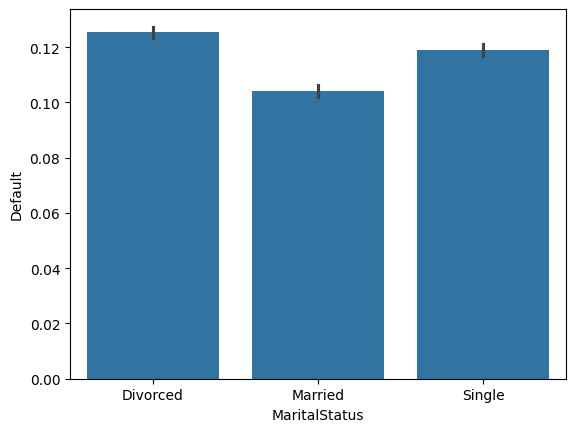

In [323]:
sns.barplot(x=df["MaritalStatus"], y=df["Default"])
plt.show()


In [324]:
print(df["HasCoSigner"].value_counts(normalize=True))


HasCoSigner
Yes    0.500108
No     0.499892
Name: proportion, dtype: float64


In [325]:
df['Default'].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [327]:
num_features = ["Age", "Income", "LoanAmount", "CreditScore", 
                "MonthsEmployed", "InterestRate",'NumCreditLines','DTIRatio']

cat_features = ["Education", "EmploymentType", "LoanPurpose"]

target = "Default"


In [ ]:
X = df[num_features + cat_features]  
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_ordinal=X_train
X_test_ordinal=X_test
y_train_ordinal=y_train
y_test_ordinal=y_test


In [329]:
encoder = OrdinalEncoder()
X_train_ordinal[cat_features] = encoder.fit_transform(X_train[cat_features])
X_test_ordinal[cat_features] = encoder.transform(X_test[cat_features])
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

In [330]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_ordinal[num_features] = scaler.fit_transform(X_train[num_features])
X_test_ordinal[num_features] = scaler.transform(X_test[num_features])
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [331]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier( eval_metric="logloss", random_state=42,max_depth=3,learning_rate=0.1,n_estimators=200,scale_pos_weight=225694 / 29653)
xgb_model.fit(X_train_ordinal, y_train_ordinal)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = xgb_model.predict(X_test_ordinal)
y_proba = xgb_model.predict_proba(X_test_ordinal)[:, 1]

In [333]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print("Accuracy:", accuracy_score(y_test_ordinal, y_pred))
print("Classification Report:\n", classification_report(y_test_ordinal, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_ordinal, y_pred))
print("AUC Score:", roc_auc_score(y_test_ordinal, y_proba))


Accuracy: 0.6872136283532406
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.69      0.80     45139
           1       0.22      0.69      0.34      5931

    accuracy                           0.69     51070
   macro avg       0.58      0.69      0.57     51070
weighted avg       0.86      0.69      0.74     51070

Confusion Matrix:
 [[31022 14117]
 [ 1857  4074]]
AUC Score: 0.7530286270727574


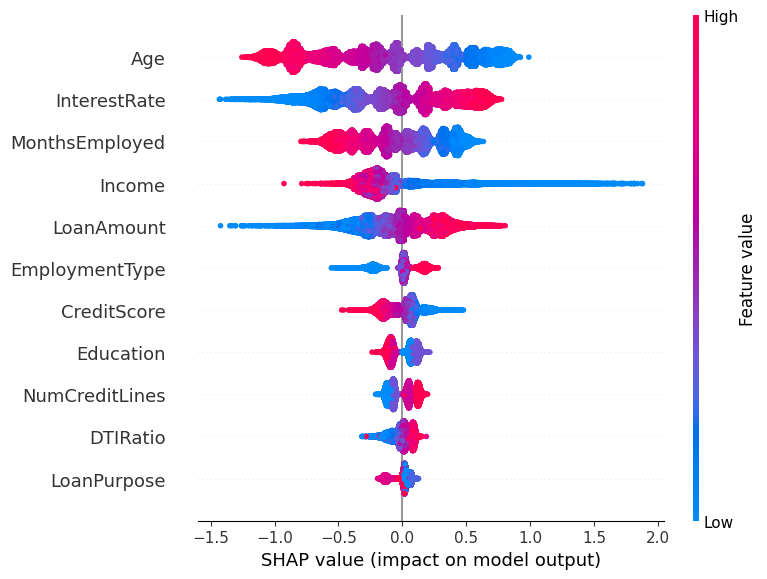

In [302]:
import shap

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_ordinal)

shap.summary_plot(shap_values, X_test_ordinal)


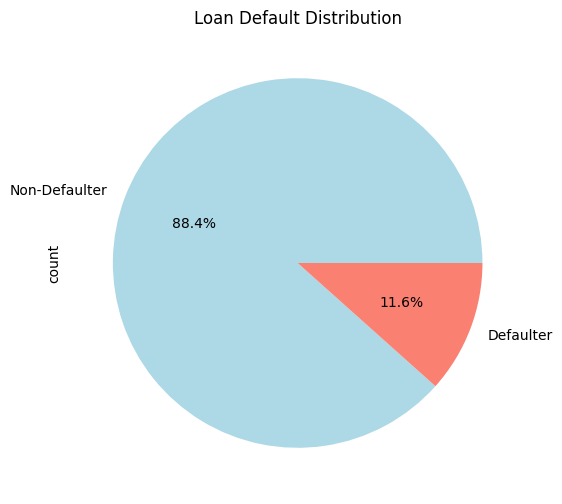

In [303]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
df['Default'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Non-Defaulter', 'Defaulter'], colors=['lightblue', 'salmon'])
plt.title("Loan Default Distribution")
plt.show()


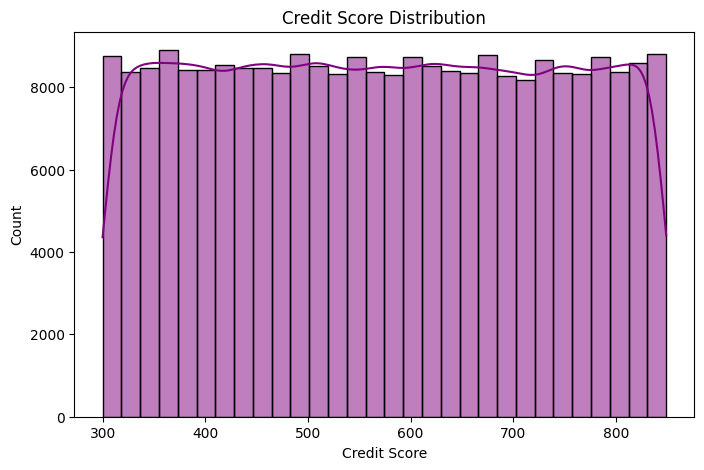

In [304]:
plt.figure(figsize=(8, 5))
sns.histplot(df['CreditScore'], bins=30, kde=True, color='purple')
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Count")
plt.show()


In [305]:

joblib.dump(xgb_model, "loan_default.pkl")

['loan_default.pkl']

In [306]:
df.columns

Index(['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
       'NumCreditLines', 'InterestRate', 'DTIRatio', 'Education',
       'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents',
       'LoanPurpose', 'HasCoSigner', 'Default'],
      dtype='object')

In [307]:
df['Education'].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [308]:
print("Train Features:", list(X_train.columns))

Train Features: ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'InterestRate', 'NumCreditLines', 'DTIRatio', 'Education', 'EmploymentType', 'LoanPurpose']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500, random_state=42,max_depth=3)
rf_model.fit(X_train_ordinal, y_train_ordinal)
y_pred = rf_model.predict_proba(X_test_ordinal)[:, 1]  # Get probabilities for ROC AUC
roc_score = roc_auc_score(y_test_ordinal, y_pred)
# print(accuracy_score(y_test_ordinal,y_pred))
print(f"ROC AUC Score: {roc_score:.2f}")
print(f'')

ROC AUC Score: 0.73


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter grid
param_dist = {
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42,n_estimators=100)

# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Number of random combinations to try
    scoring="roc_auc",
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit to training data
random_search.fit(X_train_ordinal, y_train_ordinal)

# Best parameters
print("Best Parameters:", random_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\mishj\Desktop\ML\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mishj\Desktop\ML\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mishj\Desktop\ML\myenv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\mishj\Desktop\ML\myenv\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\mishj

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}


In [ ]:
print(random_search.best_score_)

0.7431742787312221


In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = xgb_model.predict(X_test_ordinal)
cm = confusion_matrix(y_test_ordinal, y_pred)
TP = cm[1, 1]  
FN = cm[1, 0] 
sensitivity = TP / (TP + FN)
print("Sensitivity (Recall for Default Class):", sensitivity)


Sensitivity (Recall for Default Class): 0.6868993424380374


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


In [343]:

base_estimator = DecisionTreeClassifier(max_depth=2)  
adaboost_model = AdaBoostClassifier(estimator=base_estimator, n_estimators=200, learning_rate=0.5, random_state=42)
adaboost_model.fit(X_train_ordinal, y_train_ordinal)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [344]:

y_pred = adaboost_model.predict(X_test_ordinal)
y_pred_proba = adaboost_model.predict_proba(X_test_ordinal)[:, 1] 


In [345]:
auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC Score:", auc)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


ROC AUC Score: 0.7500520162137366
Accuracy: 0.8860975132171529
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94     45139
           1       0.59      0.06      0.11      5931

    accuracy                           0.89     51070
   macro avg       0.74      0.53      0.53     51070
weighted avg       0.86      0.89      0.84     51070

Confusion Matrix:
 [[44883   256]
 [ 5561   370]]


In [346]:
joblib.dump(adaboost_model, "loan_default.pkl")

['loan_default.pkl']

In [342]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}
grid_search = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train_ordinal, y_train)
print("Best Parameters:", grid_search.best_params_)
best_adaboost = grid_search.best_estimator_
y_pred_proba = best_adaboost.predict_proba(X_test_ordinal)[:, 1]
print("Improved ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Best Parameters: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.5, 'n_estimators': 200}
Improved ROC AUC Score: 0.7500520162137366
